<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_85-15/blob/main/Update_75_25_H2_T3_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

In [3]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [4]:
# Fix random seed for reproducibility
tf.random.set_seed(42)
plt.rcParams['figure.figsize'] = (12,6)

In [5]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
data = df['Nilai Ekspor Migas'].values.astype('float32').reshape(-1, 1)

In [6]:
# Statistik Deskriptif
df['Nilai Ekspor Migas'].describe()

,Nilai Ekspor Migas
count,276.000000
mean,1676.342029
std,768.702279
min,560.900000
25%,1122.675000
50%,1422.750000
75%,2101.000000
max,4091.600000


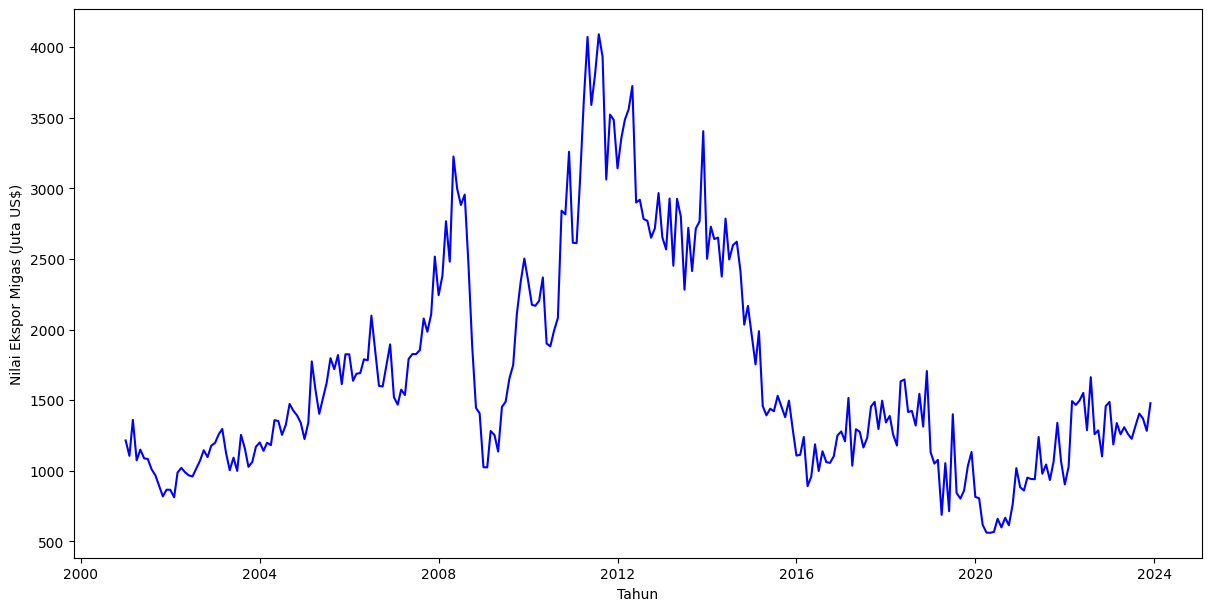

In [7]:
# Line plot data time series
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    xs = series['Tanggal']
    ys = series['Nilai Ekspor Migas']

    plt.plot(xs, ys, label=series_name, color='blue')

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
df_sorted = df.sort_values('Tanggal', ascending=True)
_plot_series(df_sorted, '')

# Menambahkan bingkai kotak
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

sns.despine(fig=fig, ax=ax, top=False, right=False, bottom=False, left=False)
plt.xlabel('Tahun')
_ = plt.ylabel('Nilai Ekspor Migas (Juta US$)')

plt.show()

In [8]:
# Uji kestasioneran (Augmented Dickey-Fuller Test)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

result_original = sm.tsa.adfuller(data)
print('ADF Statistic :', result_original[0])
print('p-value :', result_original[1])
print('Critical :')
for key, value in result_original[4].items():
    print(f'   {key}: {value}')

ADF Statistic : -2.0481781387920948
p-value : 0.2658560561741424
Critical :
   1%: -3.4544435065994437
   5%: -2.8721468827772774
   10%: -2.572422013959188


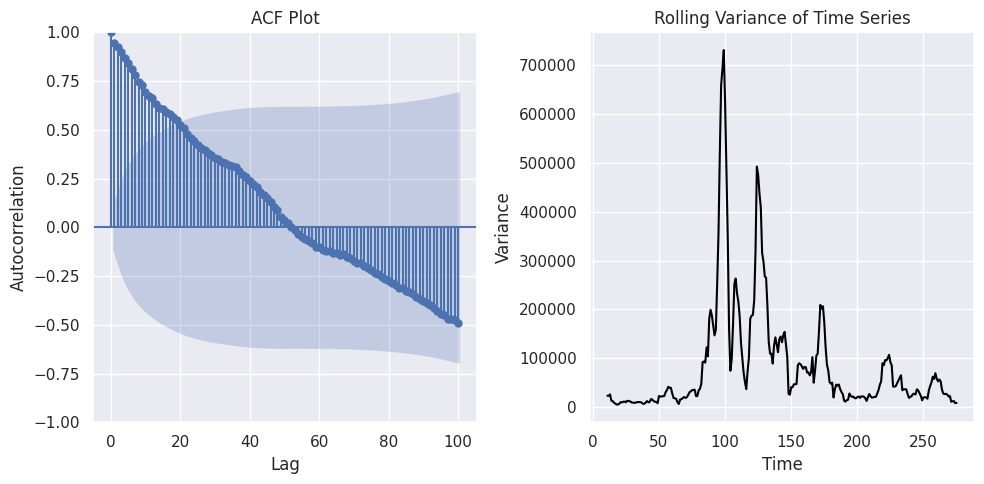

In [9]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Mengatur gaya seaborn
sns.set()

# Mengambil kolom 'Nilai Ekspor Migas' sebagai series
series = df['Nilai Ekspor Migas']

# Membuat ACF Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(series, ax=ax[0], lags=100)
ax[0].set_title('ACF Plot')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

# Menghitung varians bergulir dengan window size 12 (misal: bulanan untuk data tahunan)
rolling_variance = series.rolling(window=12).var()

# Membuat plot rolling variance
ax[1].plot(rolling_variance, color='black')
ax[1].set_title('Rolling Variance of Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
# Fungsi untuk membuat dataset
def create_dataset(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [12]:
# Prepare data
time_steps = 3
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
# Split data into training and testing sets
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, sep='\n')

(204, 3, 1)
(69, 3, 1)


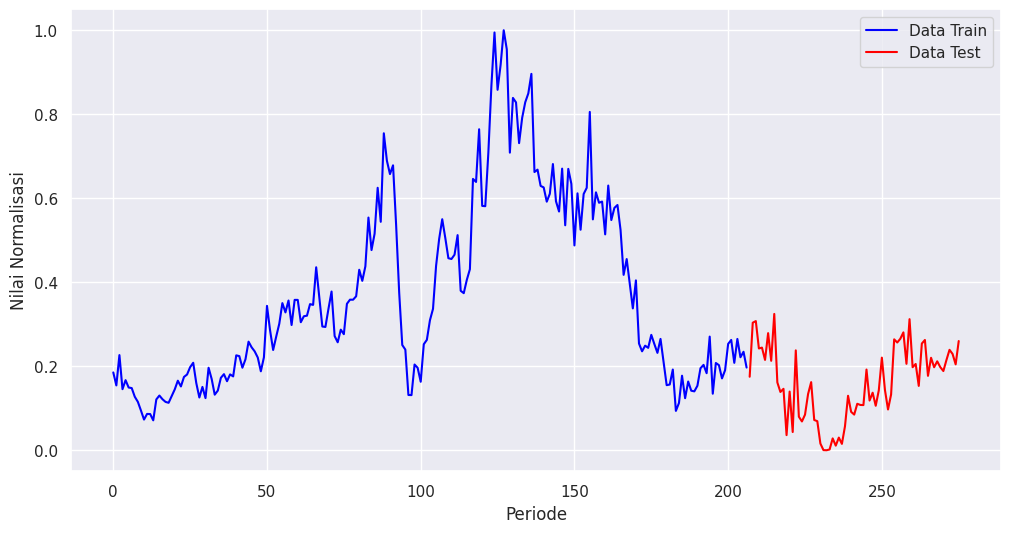

In [14]:
plt.figure(figsize=(12, 6))

bagi_train = int(len(scaled_data)*0.75)
bagi_test = len(scaled_data) - bagi_train
Xnorm_train, Xnorm_test = scaled_data[:bagi_train, :], scaled_data[bagi_train:, :]

# Plot X_train setelah normalisasi
plt.plot(range(len(Xnorm_train)), Xnorm_train, color='blue', label='Data Train')

# Plot X_test setelah normalisasi (dimulai dari akhir X_train)
plt.plot(range(len(Xnorm_train), len(Xnorm_train) + len(Xnorm_test)), Xnorm_test, color='red', label='Data Test')

# Menambahkan label dan legenda
plt.xlabel('Periode')
plt.ylabel('Nilai Normalisasi')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

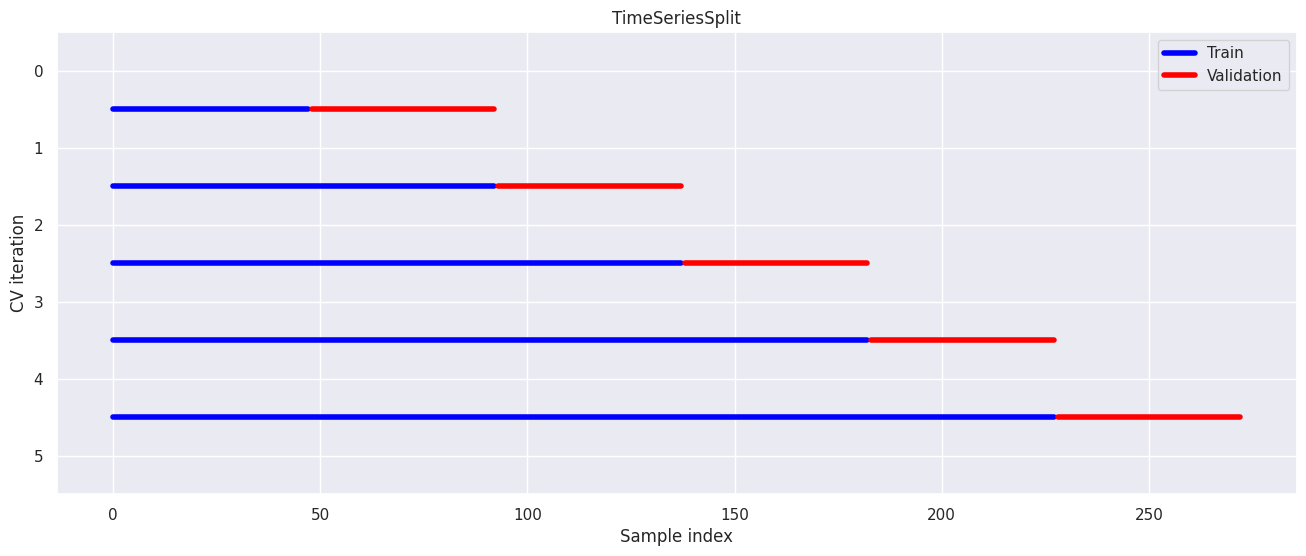

In [16]:
# Visualisasi TimeSeriesSplit
def plot_time_series_cv(tscv, X):
    plt.figure(figsize=(16, 6))
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        indices = np.arange(len(X))
        plt.plot(indices[train_index], [i + 0.5] * len(train_index), color = 'blue', linewidth = '4.0', label='Train' if i == 0 else '')
        plt.plot(indices[test_index], [i + 0.5] * len(test_index), color = 'red', linewidth = '4.0', label='Validation' if i == 0 else '')
    plt.ylim(-0.5, tscv.get_n_splits(X) + 0.5)
    plt.title('TimeSeriesSplit')
    plt.xlabel('Sample index')
    plt.ylabel('CV iteration')
    plt.legend(loc='best')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the smallest CV iteration at the top
    plt.show()

# Plot the TimeSeriesSplit
plot_time_series_cv(tscv, X)

In [17]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [18]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

    return np.mean(cv_scores)

In [19]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 21:26:00,307] A new study created in memory with name: no-name-2c20fc87-f4ac-476c-8b9b-0033dc6048fc


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 21:27:24,093] Trial 0 finished with value: 0.08780210465192795 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.08780210465192795.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 21:28:21,291] Trial 1 finished with value: 0.0527850016951561 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.0527850016951561.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2024-08-15 21:29:01,901] Trial 2 finished with value: 0.02072465792298317 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.02072465792298317.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2024-08-15 21:29:44,286] Trial 3 finished with value: 0.019153524190187454 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.019153524190187454.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2024-08-15 21:30:25,828] Trial 4 finished with value: 0.0069237081333994865 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.0069237081333994865.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2024-08-15 21:31:15,657] Trial 5 finished with value: 0.010875729843974113 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.0069237081333994865.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2024-08-15 21:31:47,675] Trial 6 finished with value: 0.024779323488473892 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.0069237081333994865.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2024-08-15 21:32:34,318] Trial 7 finished with value: 0.006839541252702475 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.006839541252702475.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2024-08-15 21:33:13,241] Trial 8 finished with value: 0.018756134435534477 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.006839541252702475.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


[I 2024-08-15 21:34:12,795] Trial 9 finished with value: 0.008238587528467178 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.006839541252702475.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step


[I 2024-08-15 21:35:05,476] Trial 10 finished with value: 0.006142675410956144 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006142675410956144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step


[I 2024-08-15 21:35:44,088] Trial 11 finished with value: 0.007185447029769421 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006142675410956144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step


[I 2024-08-15 21:36:26,574] Trial 12 finished with value: 0.00744792353361845 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006142675410956144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2024-08-15 21:37:13,885] Trial 13 finished with value: 0.006798643618822098 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006142675410956144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 21:37:59,384] Trial 14 finished with value: 0.006082538515329361 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2024-08-15 21:38:50,463] Trial 15 finished with value: 0.007116840686649084 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step


[I 2024-08-15 21:39:53,071] Trial 16 finished with value: 0.061608098447322845 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2024-08-15 21:40:36,804] Trial 17 finished with value: 0.006147375795990229 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2024-08-15 21:41:14,637] Trial 18 finished with value: 0.008413230068981647 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 21:42:17,020] Trial 19 finished with value: 0.04781675338745117 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step


[I 2024-08-15 21:42:54,205] Trial 20 finished with value: 0.008484406396746635 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 21:43:37,448] Trial 21 finished with value: 0.006808535661548376 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2024-08-15 21:44:22,974] Trial 22 finished with value: 0.006441156379878521 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2024-08-15 21:45:02,618] Trial 23 finished with value: 0.006909526884555817 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 21:45:42,915] Trial 24 finished with value: 0.006968197878450155 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 21:46:22,199] Trial 25 finished with value: 0.007142846938222647 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.006082538515329361.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2024-08-15 21:47:13,947] Trial 26 finished with value: 0.0060671172104775906 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step


[I 2024-08-15 21:47:58,362] Trial 27 finished with value: 0.006867625750601292 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 21:48:36,251] Trial 28 finished with value: 0.026749446988105774 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2024-08-15 21:50:22,888] Trial 29 finished with value: 0.0720750018954277 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 21:51:27,370] Trial 30 finished with value: 0.1043604165315628 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 21:52:18,040] Trial 31 finished with value: 0.006585112307220697 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2024-08-15 21:53:12,397] Trial 32 finished with value: 0.006324226502329111 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step


[I 2024-08-15 21:54:00,262] Trial 33 finished with value: 0.00688572833314538 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 21:54:44,351] Trial 34 finished with value: 0.006817363202571869 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2024-08-15 21:55:20,831] Trial 35 finished with value: 0.009140457957983017 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2024-08-15 21:56:03,635] Trial 36 finished with value: 0.010955972597002983 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2024-08-15 21:56:37,418] Trial 37 finished with value: 0.044934313744306564 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2024-08-15 21:57:28,321] Trial 38 finished with value: 0.06747584044933319 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2024-08-15 21:58:09,361] Trial 39 finished with value: 0.022585365921258926 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 21:59:05,479] Trial 40 finished with value: 0.009151963517069817 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2024-08-15 21:59:46,639] Trial 41 finished with value: 0.00747179239988327 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step


[I 2024-08-15 22:00:22,771] Trial 42 finished with value: 0.007435880601406097 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 22:01:05,526] Trial 43 finished with value: 0.00682817492634058 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 22:01:46,334] Trial 44 finished with value: 0.006700353231281042 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2024-08-15 22:02:50,854] Trial 45 finished with value: 0.006293960846960545 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step


[I 2024-08-15 22:03:37,046] Trial 46 finished with value: 0.015118032693862915 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2024-08-15 22:04:22,522] Trial 47 finished with value: 0.007260877639055252 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 22:05:04,508] Trial 48 finished with value: 0.007888751104474068 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 26 with value: 0.0060671172104775906.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2024-08-15 22:05:52,310] Trial 49 finished with value: 0.005660568363964558 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 49 with value: 0.005660568363964558.


Best parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}
Best value: 0.005660568363964558


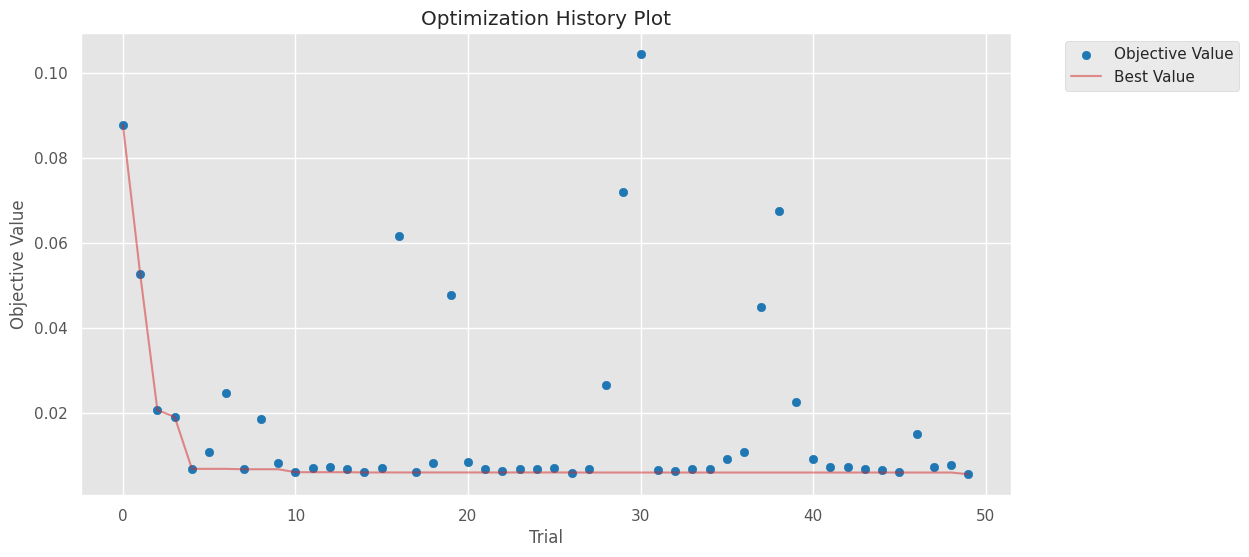

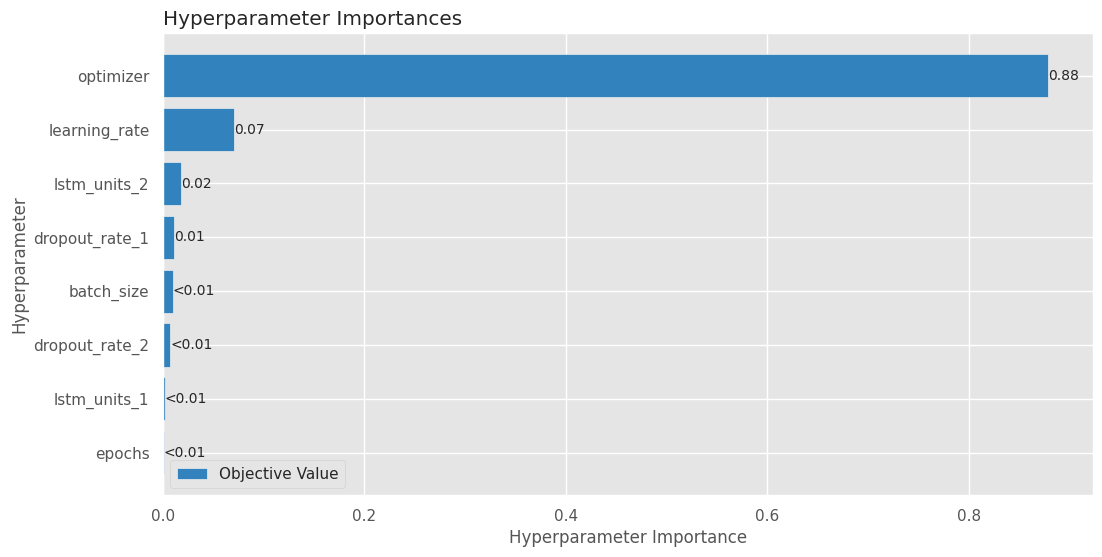

In [20]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [21]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.1085 - val_loss: 0.0029
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0516 - val_loss: 0.0084
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0218 - val_loss: 0.0188
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215 - val_loss: 0.0018
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - val_loss: 0.0034
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0115 - val_loss: 0.0050
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0133 - val_loss: 0.0022
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0094 - val_loss: 0.0069
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139 - val_lo

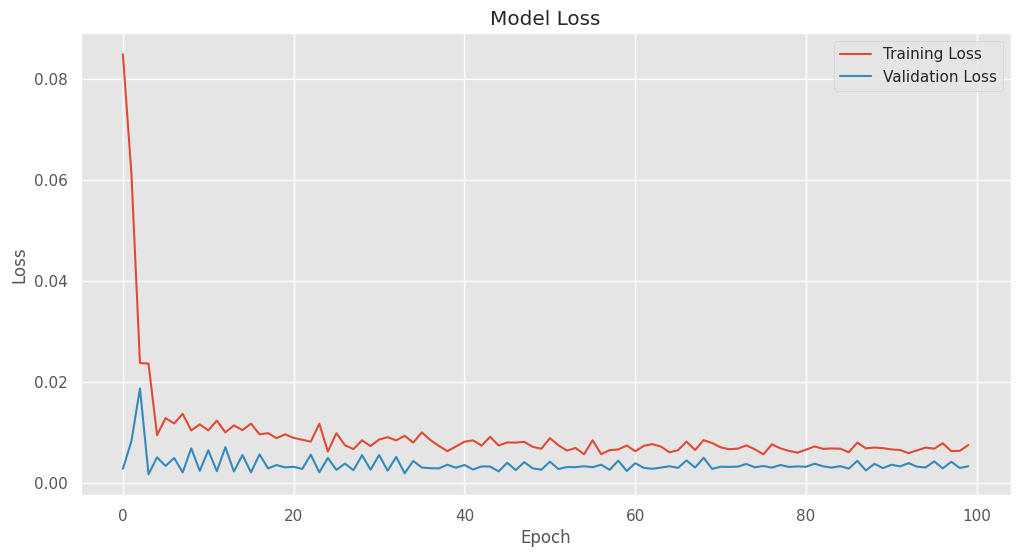

Average Loss: 0.0096


In [22]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [23]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [24]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [26]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 178.082
Root Mean Square Error: 245.360
Mean Absolute Percentage Error: 9.766%

evaluasi model data test:
Mean Absolute Error: 173.697
Root Mean Square Error: 221.486
Mean Absolute Percentage Error: 16.171%



In [27]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

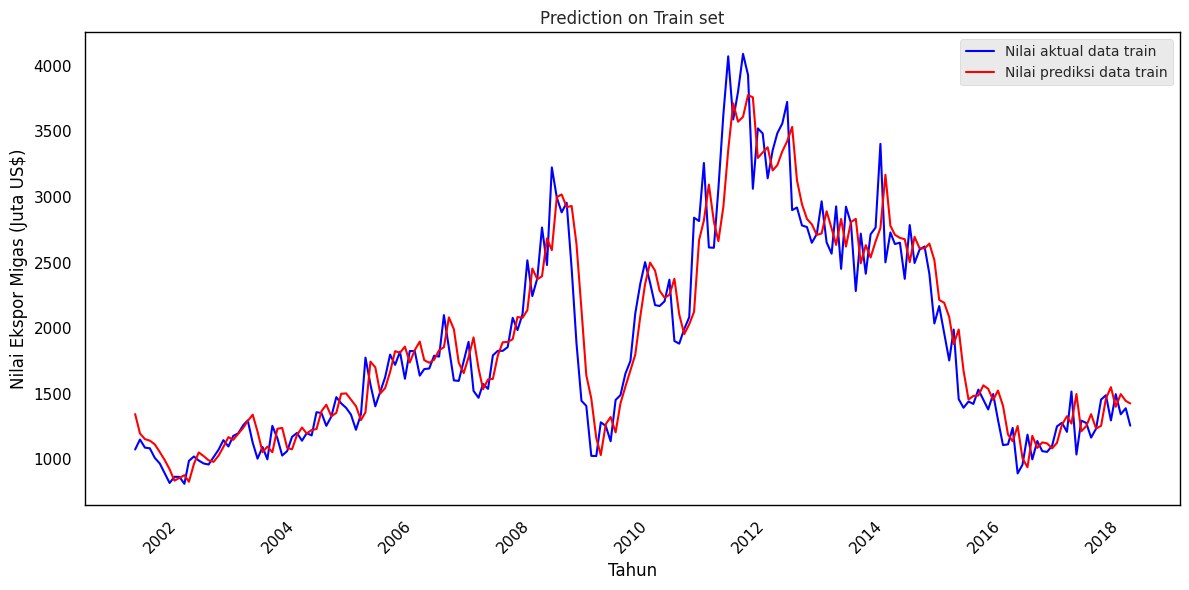

In [28]:
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

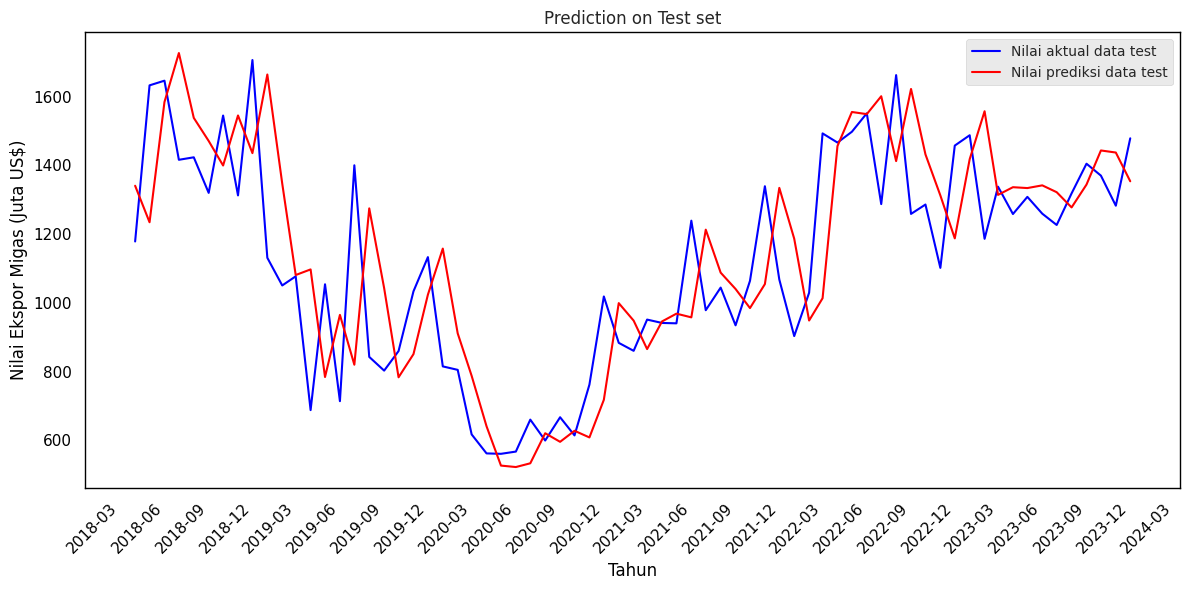

In [29]:
import matplotlib.dates as mdates

# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

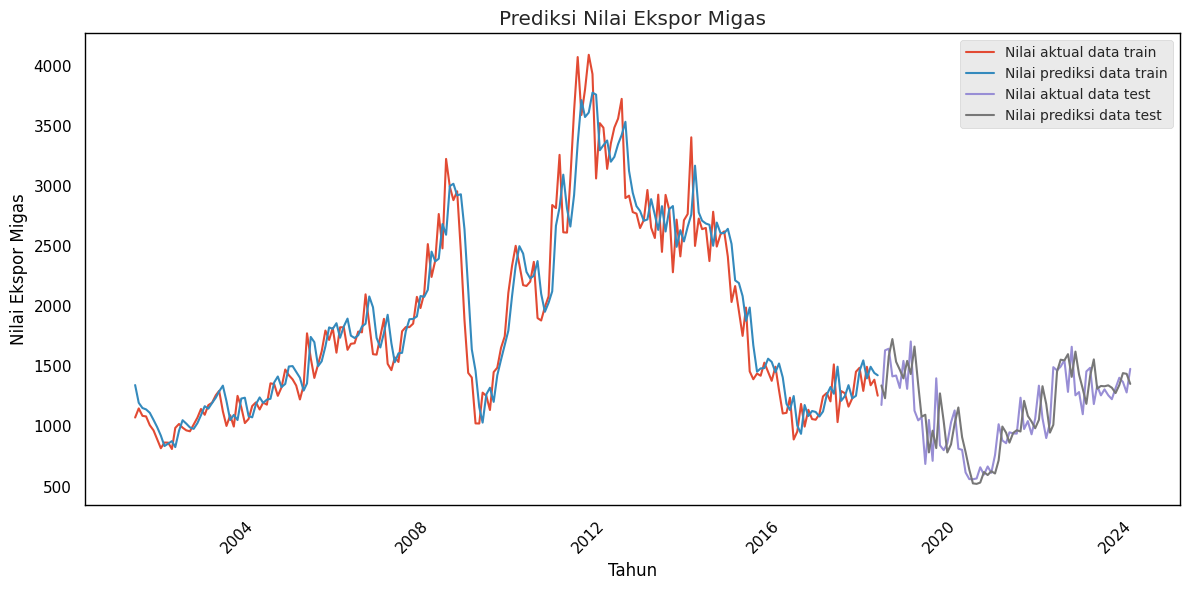

In [30]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1484.357178
1  2024-02-01                     1551.289795
2  2024-03-01                     1596.464966
3  2024-04-01                     1650.935791
4  2024-05-01                     1703.431152
5  2024-06-01                     1757.572510
6  2024-07-01                     1811.719971
7  2024-08-01                     1866.043823
8  2024-09-01                     1920.095215
9  2024-10-01                     1973.639893
10 2024-11-01                     2026

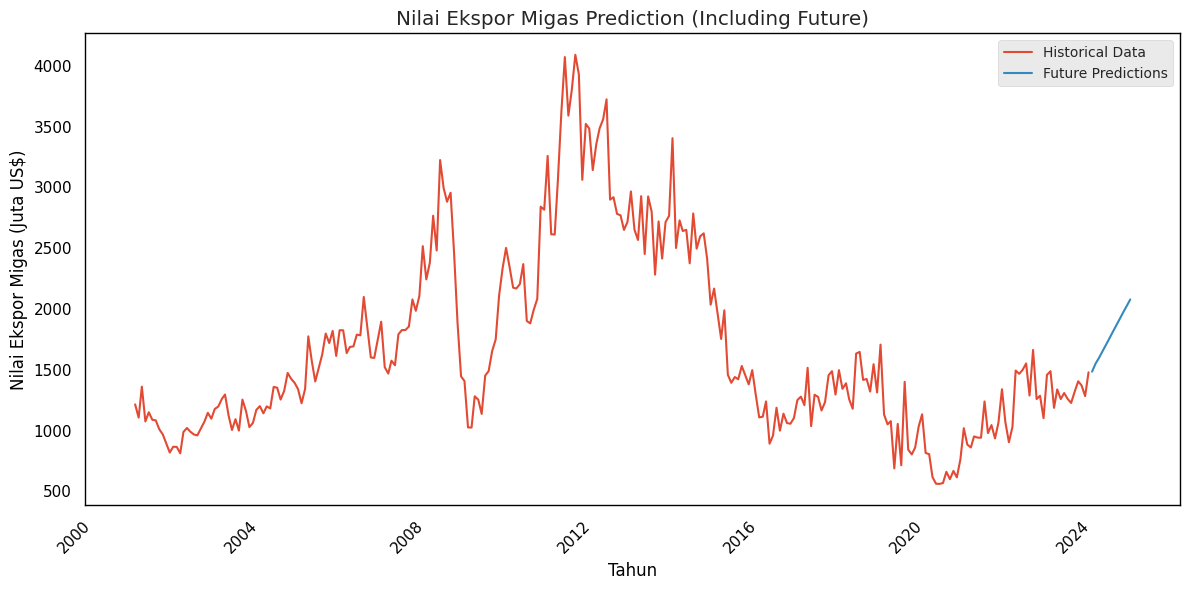

In [31]:
# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_data[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

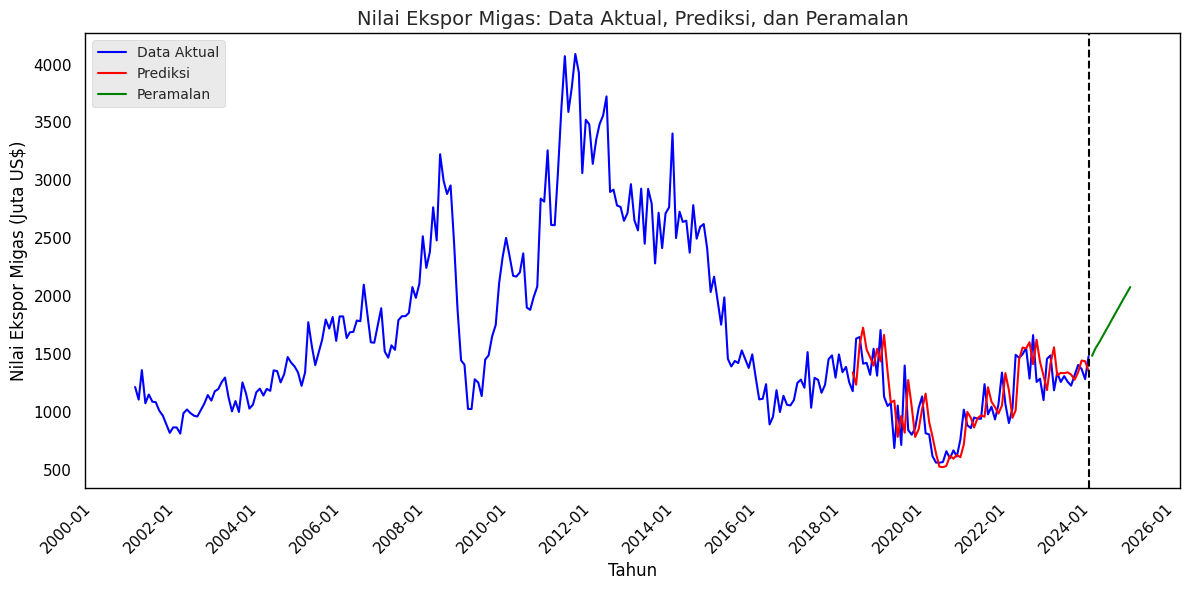

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [33]:
!pip install openpyxl

In [34]:
forecast_df.to_excel('forecast_data_h2t1.xlsx', index=False)
from google.colab import files
files.download('forecast_data_h2t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_data_h2t1.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_data_h2t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>